<a href="https://colab.research.google.com/github/Patric/fkd-gs/blob/master/notebook/FakeNewsDetectionGraphSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake news detection using graph solutions

This notebook is a walkthrough feature selection process and machine learning effects of Fake news detection using graph solution Master's Thesis.

First launch Dataset loading with 15 hidden cells,
then feature selection and testing classifiers can be launched independetly - just needs setting prerequisites section


To prevent disconencting paste the following script into your browser's console:
```
function ClickConnect() {
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect, 60000)

```

# Code formatting
Use !black command once to format the code, then use F5 and then save. Uncomment when needed

In [ ]:
# ! pip install black[jupyter]

In [ ]:
# !black /content/drive/MyDrive/ColabNotebooks/FakeNewsDetectionGraphSolutions.ipynb

# Dataset loading

## Mount google drive with processed features and define dataset paths

In [19]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libs for operating on datasets

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from enum import Enum

### Set datasets paths variables and map column names to features

Warning!!! These are Colab based paths. As for now data should be saved to your google drive from https://drive.google.com/drive/folders/1HOEIyiiFBALoqrHN5Jh8RczkvMIgUVyH?usp=sharing
 Paths should be adjusted accordingly

In [21]:
# variable should be adjusted according to your google drive TODO: figure out how to bond datasets more simply
features_directory_path = "/content/drive/MyDrive/FakeNewsDetectonColabNotebooks/resources/features"

politifact_more_than_1_relation_path = (
    f"{features_directory_path}/politifact_more_than_1_relation/"
)
politifact_all_path = f"{features_directory_path}/politifact_all/"
gossipcop_path = f"{features_directory_path}/gossipcop/"

e13_followers_path = f"{features_directory_path}/MIB/E13/"
fsf_followers_path = f"{features_directory_path}/MIB/FSF/"
int_followers_path = f"{features_directory_path}/MIB/INT/"
twt_followers_path = f"{features_directory_path}/MIB/TWT/"
tfp_followers_path = f"{features_directory_path}/MIB/TFP/"

politifact_gossipcop_followers_path = f"{features_directory_path}/fake_news_net_follower_network_sampled/"

russian_trolls_interactions_path = f"{features_directory_path}/russian_trolls/"

In [22]:
features_files_names = [
    "eigenvector_to_label.csv",
    "harmonic_closeness_to_label.csv",
    "hits_to_label.csv",
    "betweenness_to_label.csv",
    "closeness_to_label.csv",
    "page_rank_to_label.csv",
    "article_rank_to_label.csv",
    "degree_to_label.csv",
]

class FeatureColumnName(Enum):
  EIGENVECTOR = 'eigenvector_score'
  HARMONIC_CLOSENESS = 'harmonic_closeness_centrality'
  CLOSENESS = 'closeness_score'
  HITS_HUB = 'hits_hub'
  HITS_AUTH = 'hits_auth'
  BETWEENNESS = 'betweenness_score'
  PAGE_RANK = 'page_rank_score'
  ARTICLE_RANK = 'article_rank_score'
  OUT_DEGREE = 'outDegree'
  IN_DEGREE = 'inDegree'
  DEGREE = 'degree'

## Define util functions

In [23]:
def get_data_frame(*paths):
    paths = list(sum(paths, []))
    dfs = list(map(lambda path: pd.read_csv(path), paths))
    df = pd.concat(dfs, join="outer", axis=1)
    df = df.loc[:, ~df.columns.duplicated()].copy()
    return df


def get_feature_full_path(data_set_path, feature_data):
    return f"{data_set_path}{feature_data}"


def get_features_paths(data_set_path, features_files):
    return list(
        map(
            lambda feature_file: get_feature_full_path(data_set_path, feature_file),
            features_files,
        )
    )

In [24]:
# split into dependend and independent variables
def split_into_X_y(data_frame, dependent_variables_list, independend_variable):
  X = data_frame[dependent_variables_list]
  y = data_frame[independend_variable]

  return X, y

## Convert datasets to Pandas DataFrames

In [25]:
paths_array = [e13_followers_path, fsf_followers_path, int_followers_path, twt_followers_path, tfp_followers_path]
mib_combined = list(map(lambda dataset_path: get_data_frame(get_features_paths(dataset_path, features_files_names)), paths_array))
dfs_mib_combined = pd.concat(mib_combined)

In [26]:
df_politifact = get_data_frame(get_features_paths(politifact_all_path, features_files_names))
df_politifact_more_than_1_relation = get_data_frame(get_features_paths(politifact_more_than_1_relation_path, features_files_names))

df_gossipcop = get_data_frame(get_features_paths(gossipcop_path, features_files_names))

df_fake_news_followers = get_data_frame(get_features_paths(politifact_gossipcop_followers_path, features_files_names))

df_russian_trolls_interactions = get_data_frame(get_features_paths(russian_trolls_interactions_path, features_files_names))

df_fake_news_net_skeleton_combined = pd.concat([df_politifact, df_gossipcop])

In [27]:
datasets = {
    'politifact': df_politifact,
    'gossipcop': df_gossipcop,
    # fake_news_skeleton_combined = politifact + gossipcop
    'fake_news_skeleton_combined': df_fake_news_net_skeleton_combined,
    'mib_combined': dfs_mib_combined,
    'fake_news_followers': df_fake_news_followers,
    'russian_trolls_interactions': df_russian_trolls_interactions,
    'mib_combined_at_least_1_degree': dfs_mib_combined.copy().query('degree >= 1')
}

# Datasets metrics


In [ ]:
true_labels_count = datasets['fake_news_followers'].copy().rename(columns = {'user.label':'label'}).query('label == 1').shape
false_labels_count = datasets['fake_news_followers'].copy().rename(columns = {'user.label':'label'}).query('label == 0').shape
print('true: ', true_labels_count, 'false', false_labels_count)

true:  (541255, 9) false (272743, 9)


# Feature selection


## Set prerequisites

### Import libs for feature selection

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from IPython.display import display
import seaborn as sns

### Define feature selection **functions**

In [ ]:
def select_features_chi2(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=chi2, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  results = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i])
    row = []
    row.append(fs.scores_[i])
    if hasattr(fs, 'pvalues_'):
      row.append(fs.pvalues_[i])
      results.append([fs.scores_[i], fs.pvalues_[i]])
                
  return pd.DataFrame(results, columns=['Chi2 scores', 'Chi2 pvalues'], index=feature_names)

In [ ]:
def select_features_f(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=f_classif, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  results = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i]) 
    results.append([fs.scores_[i], fs.pvalues_[i]])
                
  return pd.DataFrame(results, columns=['F-test scores', 'F-test pvalues'], index=feature_names)

In [ ]:
def select_features_mutual_info(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=mutual_info_classif, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  scores = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i]) 
    scores.append([fs.scores_[i]])

  return pd.DataFrame(scores, columns=['Mutual info scores'], index=feature_names)

In [ ]:
def select_features_r(X, y):
  # configure to select all features
  fs = SelectKBest(score_func=r_regression, k='all')
  # learn relationship from training data
  fs.fit(X, y)

  feature_names = []
  scores = []
  for i in range(len(fs.scores_)):
    feature_names.append(fs.feature_names_in_[i])
    scores.append([fs.scores_[i]])

  return pd.DataFrame(scores, columns=['Pearson scores'], index=feature_names)

In [ ]:
def tree_classifier(X, y):
  clf = ExtraTreesClassifier(n_estimators=50)
  clf = clf.fit(X, y)
  feature_names = []
  scores = []
  for i in range(len(clf.feature_importances_)):
    feature_names.append(clf.feature_names_in_[i])
    scores.append([clf.feature_importances_[i]])

  return pd.DataFrame(scores, columns=['Tree classifier importances'], index=feature_names)

In [ ]:
def plot_pearson_corr_matrix(data_frame, name):
  corr = data_frame.corr(method='pearson')
  plt.figure(figsize=(12, 5))
  # Increase the size of the 
  heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
  heatmap.set_title(f'{name} pearson correlation Heatmap', fontdict={'fontsize':12}, pad=12)
  plt.show()

In [ ]:
def test_linear_regression_model(X_train, y_train, X_test, y_test):
  linreg=LinearRegression()
  linreg.fit(X_train,y_train)
  y_pred=linreg.predict(X_test)
  Accuracy=r2_score(y_test,y_pred)*100
  print(" Accuracy of the model is %.2f" %Accuracy)
  plt.scatter(y_test,y_pred)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()
  sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')
  plt.show()

In [ ]:
features_included_default = [
          FeatureColumnName.EIGENVECTOR.value,
          FeatureColumnName.HARMONIC_CLOSENESS.value,
          FeatureColumnName.HITS_HUB.value,
          FeatureColumnName.HITS_AUTH.value,
          FeatureColumnName.BETWEENNESS.value,
          FeatureColumnName.CLOSENESS.value,
          FeatureColumnName.PAGE_RANK.value,
          FeatureColumnName.ARTICLE_RANK.value,
          FeatureColumnName.OUT_DEGREE.value,
          FeatureColumnName.IN_DEGREE.value,
          FeatureColumnName.DEGREE.value
          ]

In [ ]:
def test_feature_dependency_for_dataset(df, df_name='Data frame',features_included=features_included_default):  
  label_column_name = 'user.label'
  X, y = split_into_X_y(df, features_included, label_column_name)

  plot_pearson_corr_matrix(df, df_name)
  df_mi = select_features_mutual_info(X, y)
  df_f = select_features_f(X, y)
  df_chi2 = select_features_chi2(X, y)
  df_r = select_features_r(X, y)
  df_t =  tree_classifier(X, y)
  df_output = pd.concat([df_mi, df_f, df_chi2, df_r, df_t], axis=1)

  with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:.3f}'.format):
    display(df_output)

  print(f'Linear regression of features: {features_included}')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
  test_linear_regression_model(X_train, y_train, X_test, y_test)

## Test feature dependency

### Select fake news net follower net features
In this case most significant features turned out to be page rank score and article score - page rank chosen as they were both correlated

        eigenvector_score  harmonic_closeness_centrality      hits_hub  \
0            1.867392e-06                       0.174367  2.253615e-07   
1            7.297052e-09                       0.143610  1.982937e-10   
2            7.297052e-09                       0.143610  1.982937e-10   
3            7.297052e-09                       0.143610  1.982937e-10   
4            7.297052e-09                       0.143610  1.982937e-10   
...                   ...                            ...           ...   
813993       9.343155e-04                       0.249810  0.000000e+00   
813994       2.313519e-06                       0.177668  0.000000e+00   
813995       2.922783e-05                       0.203341  0.000000e+00   
813996       2.463383e-04                       0.241632  0.000000e+00   
813997       2.374827e-06                       0.182128  0.000000e+00   

           hits_auth  closeness_score  page_rank_score  article_rank_score  
0       8.426490e-08         0.171

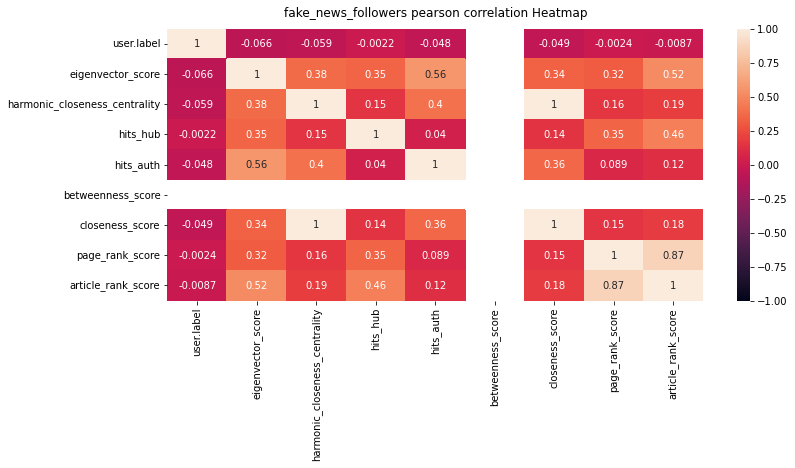

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.244,3560.221,0.000,19.645,0.000,-0.066,0.163
harmonic_closeness_centrality,0.263,2828.637,0.000,3.670,0.055,-0.059,0.168
hits_hub,0.103,3.883,0.049,0.077,0.782,-0.002,0.069
hits_auth,0.261,1850.662,0.000,9.523,0.002,-0.048,0.159
closeness_score,0.260,1961.225,0.000,2.354,0.125,-0.049,0.174
page_rank_score,0.266,4.536,0.033,306.354,0.000,-0.002,0.136
article_rank_score,0.271,61.463,0.000,164.771,0.000,-0.009,0.131


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'closeness_score', 'page_rank_score', 'article_rank_score']
 Accuracy of the model is 1.68


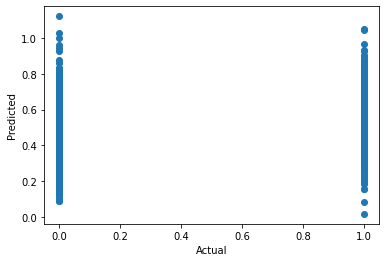

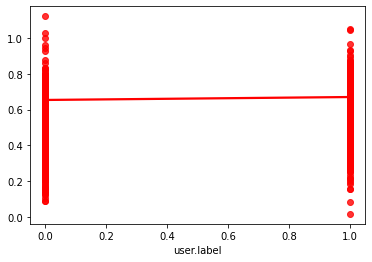

In [ ]:
name = 'fake_news_followers'
features_included = [
          FeatureColumnName.EIGENVECTOR.value,
          FeatureColumnName.HARMONIC_CLOSENESS.value,
          FeatureColumnName.HITS_HUB.value,
          FeatureColumnName.HITS_AUTH.value,
          #FeatureColumnName.BETWEENNESS.value,
          FeatureColumnName.CLOSENESS.value,
          FeatureColumnName.PAGE_RANK.value,
          FeatureColumnName.ARTICLE_RANK.value,
          #FeatureColumnName.OUT_DEGREE.value,
         # FeatureColumnName.IN_DEGREE.value,
         # FeatureColumnName.DEGREE.value
          ]
test_feature_dependency_for_dataset(datasets[name], name, features_included)

### Bulk generate corr matrices

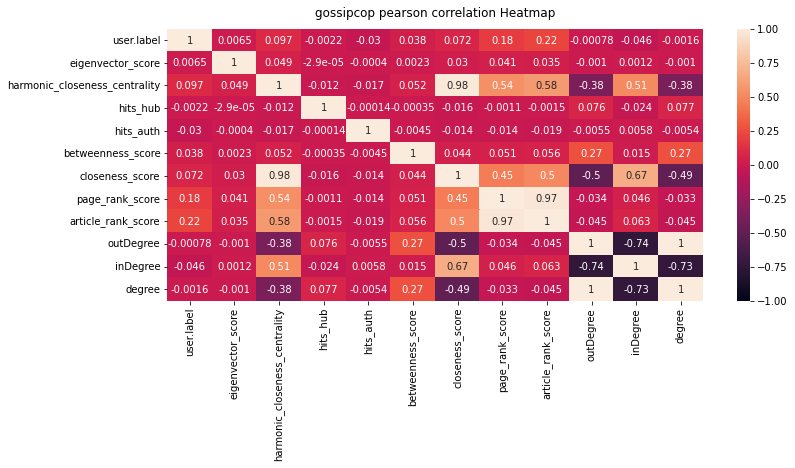

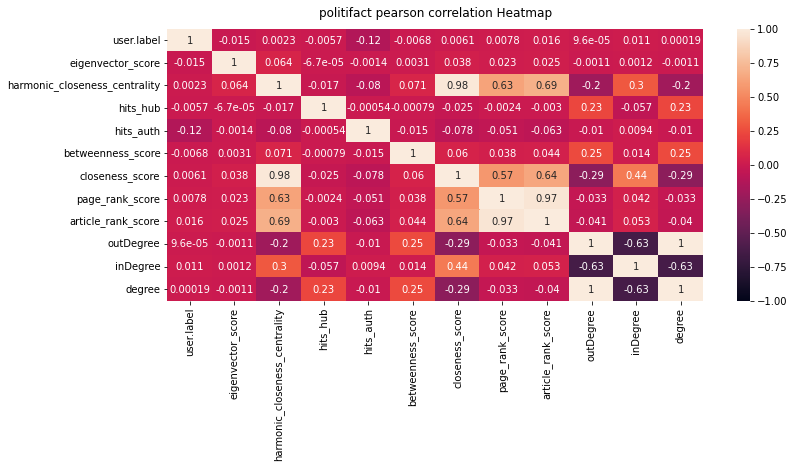

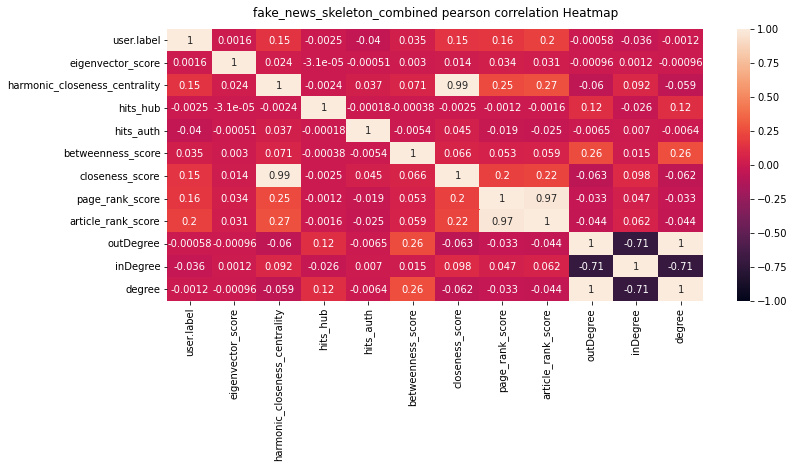

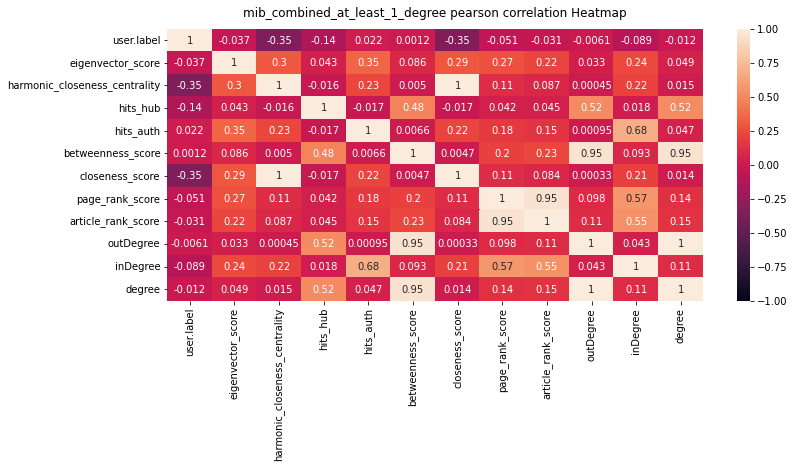

In [ ]:
name = 'gossipcop'
plot_pearson_corr_matrix(datasets[name], name)

name = 'politifact'
plot_pearson_corr_matrix(datasets[name], name)

name = 'fake_news_skeleton_combined'
plot_pearson_corr_matrix(datasets[name], name)

name = 'mib_combined_at_least_1_degree'
plot_pearson_corr_matrix(datasets[name], name)


### Select gossipcop features
In this case most significant features turned out to be page rank score and article score - page rank chosen as they were both correlated

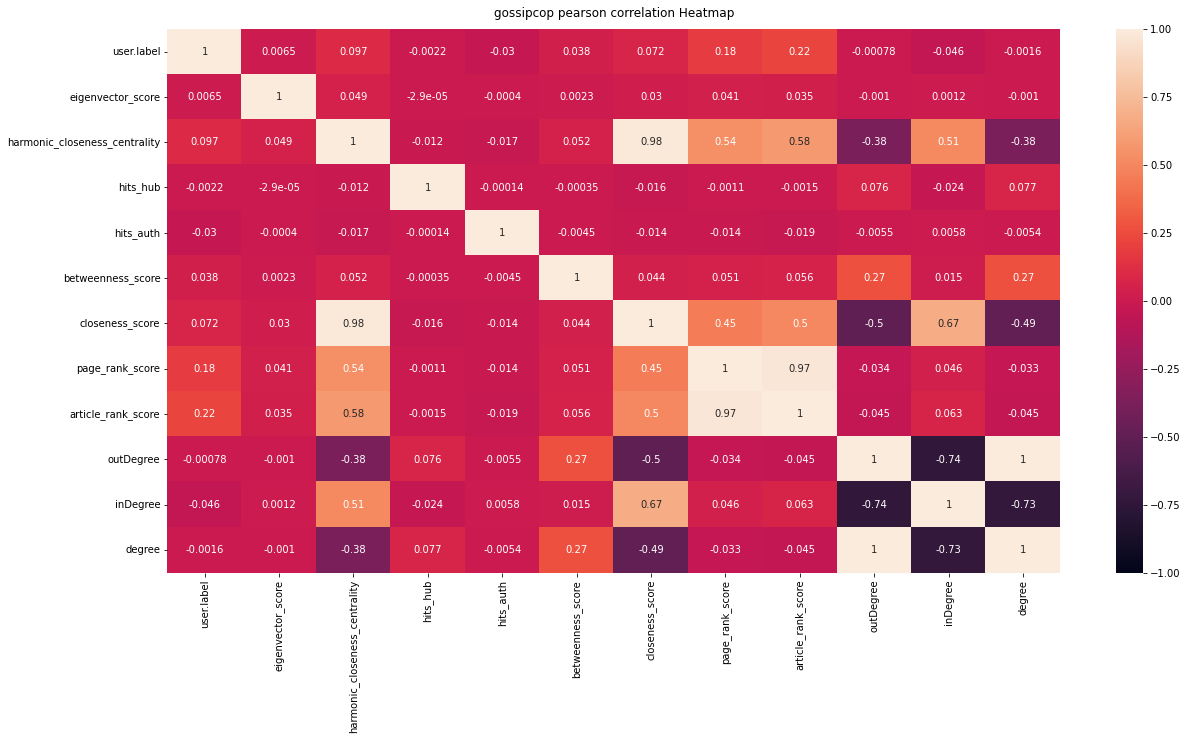

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.010,13.190,0.000,2.559,0.110,0.006,0.002
harmonic_closeness_centrality,0.011,2976.466,0.000,0.001,0.979,0.097,0.021
hits_hub,0.000,1.512,0.219,0.844,0.358,-0.002,0.000
hits_auth,0.012,282.384,0.000,11.521,0.001,-0.030,0.015
betweenness_score,0.008,445.080,0.000,12701.546,0.000,0.038,0.017
closeness_score,0.011,1637.603,0.000,0.000,0.988,0.072,0.028
page_rank_score,0.209,10651.680,0.000,69.852,0.000,0.181,0.404
article_rank_score,0.208,16389.056,0.000,23.628,0.000,0.223,0.459
outDegree,0.013,0.191,0.662,11.358,0.001,-0.001,0.025
inDegree,0.042,654.636,0.000,11.358,0.001,-0.046,0.003


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 7.95


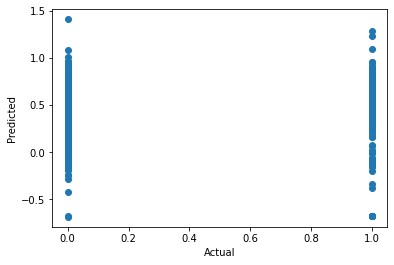

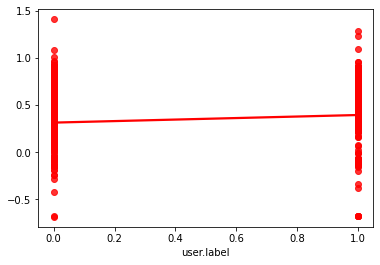

In [ ]:
name = 'gossipcop'
test_feature_dependency_for_dataset(datasets[name], name)

### Select politifact features
Most significat features chosen: page rank based on correlation and betweenness based on chi2 test

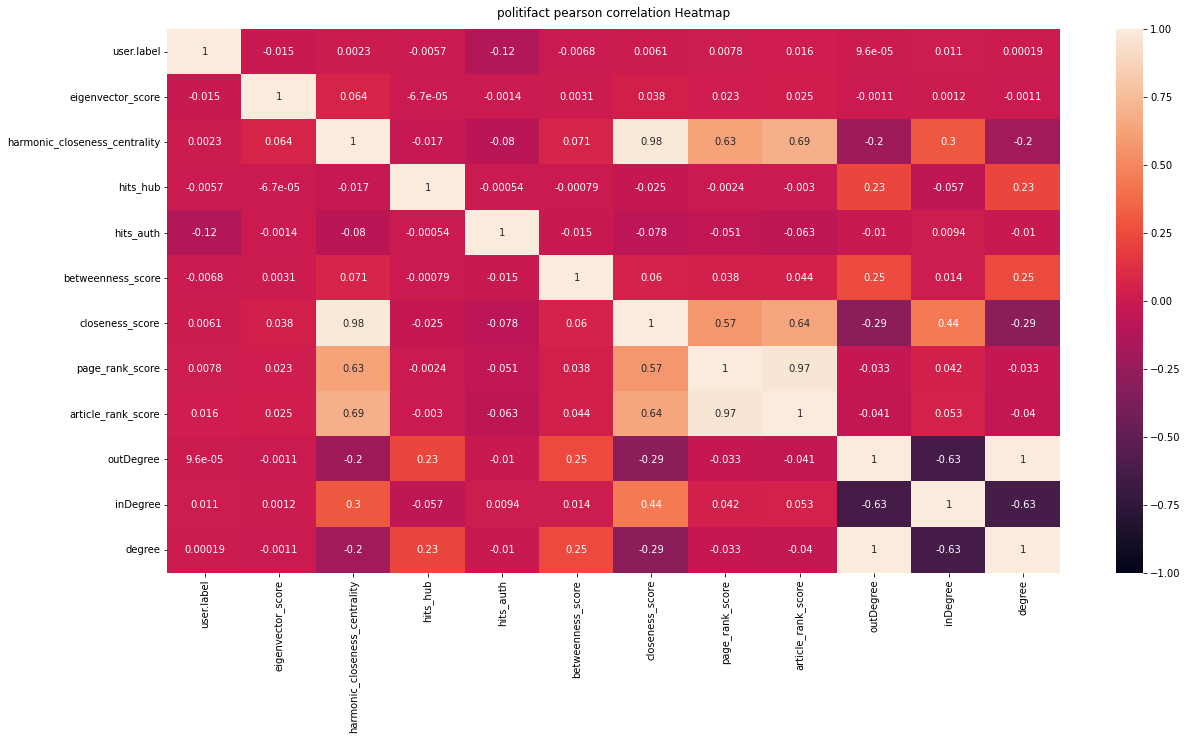

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.000,8.667,0.003,3.210,0.073,-0.015,0.001
harmonic_closeness_centrality,0.000,0.211,0.646,0.000,0.999,0.002,0.006
hits_hub,0.000,1.315,0.252,1.295,0.255,-0.006,0.000
hits_auth,0.022,607.285,0.000,27.472,0.000,-0.121,0.028
betweenness_score,0.000,1.873,0.171,74.700,0.000,-0.007,0.013
closeness_score,0.000,1.532,0.216,0.000,0.999,0.006,0.005
page_rank_score,0.563,2.527,0.112,0.037,0.847,0.008,0.461
article_rank_score,0.565,10.647,0.001,0.034,0.854,0.016,0.469
outDegree,0.000,0.000,0.984,0.036,0.850,0.000,0.008
inDegree,0.000,4.707,0.030,0.036,0.850,0.011,0.000


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 1.81


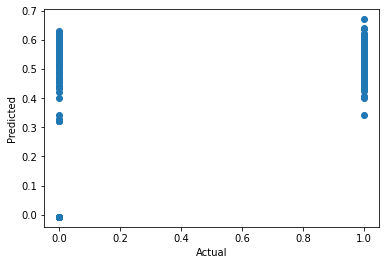

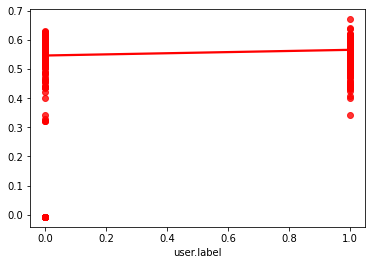

In [ ]:
name = 'politifact'
test_feature_dependency_for_dataset(datasets[name], name)

### Select gossipcop + politifact features
Na podstawei tree classifier wybrany page rank, 

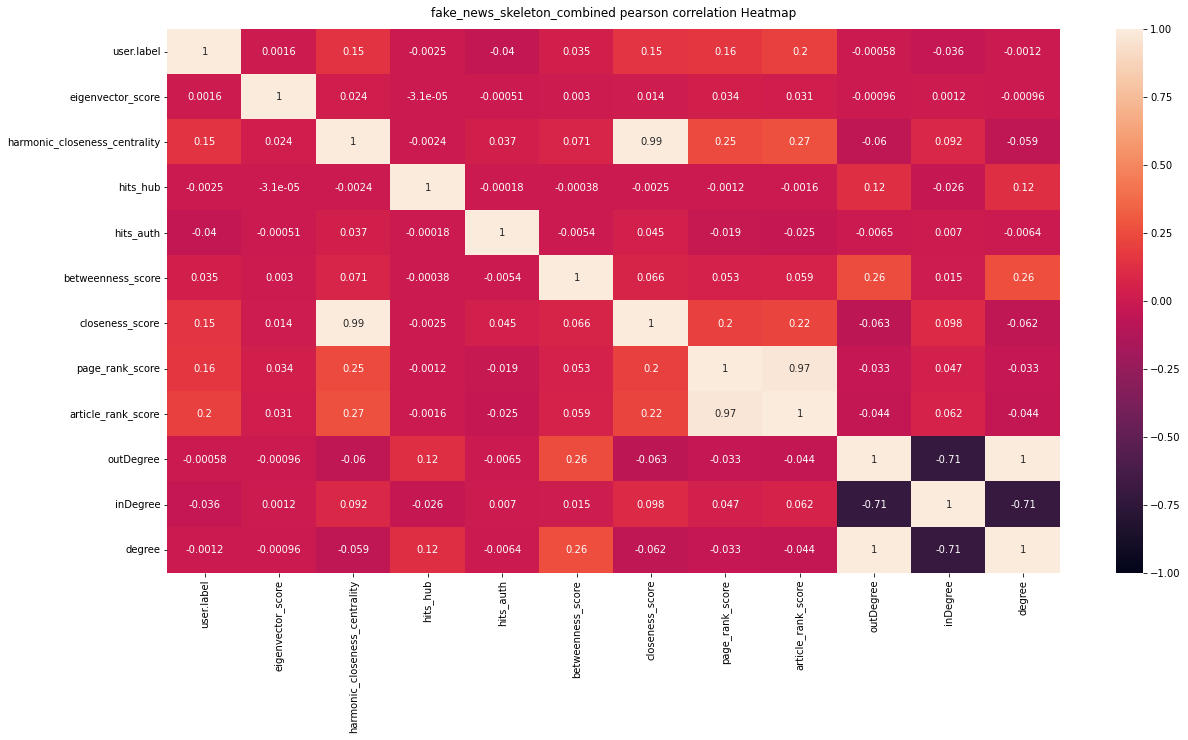

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.020,0.929,0.335,0.237,0.627,0.002,0.002
harmonic_closeness_centrality,0.020,7925.474,0.000,0.101,0.750,0.148,0.046
hits_hub,0.000,2.148,0.143,1.530,0.216,-0.002,0.000
hits_auth,0.011,583.671,0.000,25.271,0.000,-0.040,0.016
betweenness_score,0.009,438.670,0.000,13913.119,0.000,0.035,0.018
closeness_score,0.021,8073.976,0.000,0.086,0.770,0.149,0.047
page_rank_score,0.225,9778.541,0.000,74.900,0.000,0.164,0.386
article_rank_score,0.259,14958.180,0.000,25.026,0.000,0.201,0.445
outDegree,0.011,0.121,0.728,7.679,0.006,-0.001,0.018
inDegree,0.048,472.832,0.000,7.679,0.006,-0.036,0.003


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 8.03


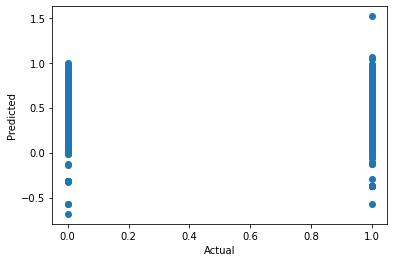

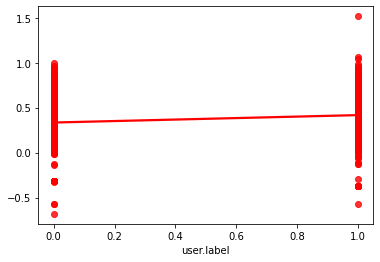

In [ ]:
# politifact + gossipcop
name = 'fake_news_skeleton_combined'
test_feature_dependency_for_dataset(datasets[name], name)

### Select MIB combined user followers network features without users with only 1 degree

Harmonic closeness chosen as the only important feature based on correlation and tree classifier and eigenvector based on mutual information

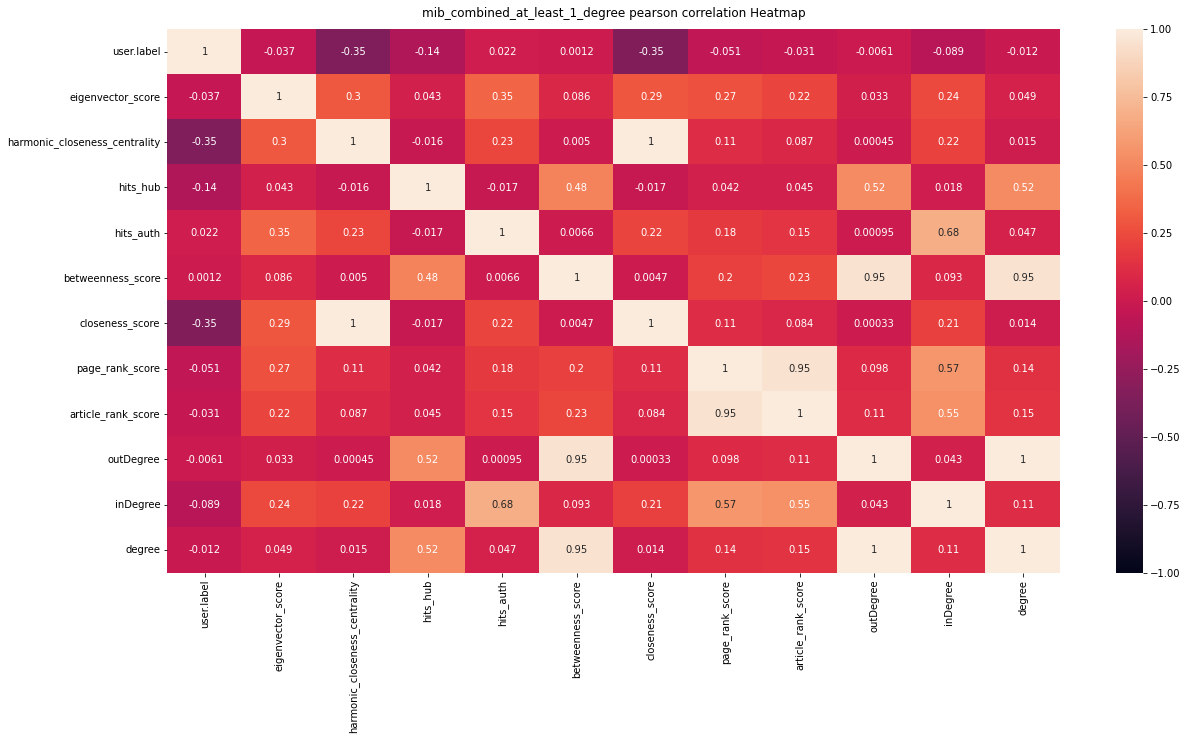

,Mutual info scores,F-test scores,F-test pvalues,Chi2 scores,Chi2 pvalues,Pearson scores,Tree classifier importances
eigenvector_score,0.245,1950.344,0.000,9.942,0.002,-0.037,0.001
harmonic_closeness_centrality,0.271,196599.696,0.000,8538.933,0.000,-0.352,0.353
hits_hub,0.190,26842.827,0.000,981.298,0.000,-0.138,0.286
hits_auth,0.248,693.709,0.000,3.032,0.082,0.022,0.036
betweenness_score,0.002,2.082,0.149,4205253238.833,0.000,0.001,0.000
closeness_score,0.271,190243.421,0.000,7738.225,0.000,-0.347,0.289
page_rank_score,0.264,3580.209,0.000,22986.895,0.000,-0.051,0.000
article_rank_score,0.260,1308.763,0.000,708.467,0.000,-0.031,0.000
outDegree,0.114,51.639,0.000,3397591.733,0.000,-0.006,0.018
inDegree,0.178,11221.404,0.000,3397591.733,0.000,-0.089,0.007


Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'article_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 25.20


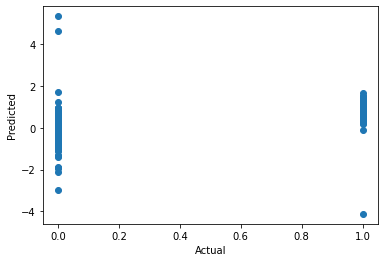

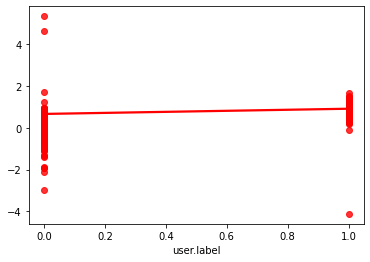

In [ ]:
name = 'mib_combined_at_least_1_degree'
test_feature_dependency_for_dataset(datasets[name], name)

### Test all at once

In [ ]:
# for dataset_name in datasets:
#   print(f'Testing feature dependency for: {dataset_name}')
#   test_feature_dependency_for_dataset(datasets[dataset_name], dataset_name)

# Classifiers testing

## Set prerequisites

### Import libs for classifiers *testing*

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from IPython.display import display
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

### Define test classifiers functions

In [29]:
metrics_cols = ["Classifier",
              "Mean Validation Accuracy",
              "Mean Validation Precision",
              "Mean Validation Recall",
              "Mean Validation F1 Score"]


In [30]:
# model = [{ model, yest, y_pred_proba, name }] }
def plot_ROC_from_models_and_reds(models_and_preds, ax):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"Mean ROC curve",
  )
  for model_and_preds in models_and_preds:
    y_test = model_and_preds['y_test']
    y_pred_proba = model_and_preds['y_pred_proba']
    model = model_and_preds['model']
    name = model.__class__.__name__
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = round(roc_auc_score(y_test, y_pred_proba), 4)
    ax.plot(fpr,tpr,label="ROC curves, AUC="+str(auc))

  ax.legend()

def cross_validation_with_ROC_plot(model, X, y, ax):
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)
  accuracies = []
  precisions = []
  recalls = []
  f1s = []

  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
      X_train = X.iloc[train_idx]
      y_train = y.iloc[train_idx]
      X_test = X.iloc[test_idx]
      y_test = y.iloc[test_idx]
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      accuracies.append(accuracy_score(y_test, y_pred))
      precisions.append(precision_score(y_test, y_pred))
      recalls.append(recall_score(y_test, y_pred))
      f1s.append(f1_score(y_test, y_pred, ))


      viz = RocCurveDisplay.from_predictions(
          y_test,
          y_pred,
          name=f"ROC fold {fold}",
          alpha=0.3,
          lw=1,
          ax=ax,
      )
      interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      aucs.append(viz.roc_auc)

  ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)

  mean_acc = np.mean(accuracies, axis=0)*100
  mean_prec = np.mean(precisions, axis=0)
  mean_rec = np.mean(recalls, axis=0)
  mean_f1 =np.mean(f1s, axis=0)
  ax.plot(
      mean_fpr,
      mean_tpr,
      color="b",
      label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
      lw=2,
      alpha=0.8,
  )

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
  ax.fill_between(
      mean_fpr,
      tprs_lower,
      tprs_upper,
      color="grey",
      alpha=0.2,
      label=r"$\pm$ 1 std. dev.",
  )


  ax.axis("square")
  return (mean_acc, mean_prec, mean_rec, mean_f1)
  #plt.show()

In [31]:
def cross_validation_custom(model, X, y):
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
  accuracies = []
  precisions = []
  recalls = []
  f1s = []

  best_model = None
  max_f1 = 0
  max_f1_y_pred = None
  max_f1_y_test = None

  models = []
  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1 = f1_score(y_test, y_pred)
    f1s.append(f1)
    if f1 > max_f1:
      max_f1 = f1
      max_f1_y_pred = y_pred
      max_f1_y_test =y_test
      best_model = model

  best_model_and_preds = {'model': best_model,
                          'y_pred_proba': max_f1_y_pred,
                          'y_test': max_f1_y_test }

  mean_acc = np.mean(accuracies, axis=0)*100
  mean_prec = np.mean(precisions, axis=0)
  mean_rec = np.mean(recalls, axis=0)
  mean_f1 = np.mean(f1s, axis=0)

  return (mean_acc, mean_prec, mean_rec, mean_f1, best_model_and_preds)

In [32]:
def cross_validation(model, classifier_name,_X, _y):
      fig, ax = plt.subplots(figsize=(8, 8))
      ax.set(
      xlim=[-0.05, 1.05],
      ylim=[-0.05, 1.05],
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=f"Mean ROC curve",
    )
      #(mean_acc, mean_prec, mean_rec, mean_f1) = cross_validation_with_ROC_plot(model, _X, _y, ax)
      (mean_acc, mean_prec, mean_rec, mean_f1, best_model_and_preds) = cross_validation_custom(model, _X, _y)
      return pd.DataFrame([[
              classifier_name,
              mean_acc,
              mean_prec,
              mean_rec,
              mean_f1]], columns=metrics_cols)
              

In [33]:
def test_classifiers_with_cv(classifiers, X, y, with_voting=False):
  log = pd.DataFrame(columns=metrics_cols)
  estimators = []
  best_model_and_preds_arr = []
  for clf in classifiers:
    name = clf.__class__.__name__
    print(name)
    results= cross_validation(clf, name, X, y)
   # best_model_and_preds_arr.append(best_model_and_preds)
    log = log.append(results)
  
  # if with_voting:
  #   vclfh = VotingClassifier(estimators=[
  #         ('1st', estimators[0]), ('2nd', estimators[1]), ('3rd', estimators[2])], voting='hard')
  #   vclfs = VotingClassifier(estimators=[
  #         ('1st', estimators[0]), ('2nd', estimators[1]), ('3rd', estimators[2])], voting='soft')
  #   results, estimator =  cross_validation(vclfh, 'VotingClassifierHard', X, y)
  #   results, estimator =  cross_validation(vclfs, 'VotingClassifierSoft', X, y)
  #   log = log.append(results)
  #plot_ROC_from_predictions(best_model_and_preds_arr)
  with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:.3f}'.format):
    display(log)

In [34]:
def test_classfiers(classifiers, X_train, X_test, y_train, y_test, with_ll=True):
  log_cols = ["Classifier", "Accuracy", "Precision", "Recall", "f1", "Log Loss"]
  log = pd.DataFrame(columns=log_cols)

  for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__

    print("=" * 30)
    print(name)

   
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    precision = precision_score(y_test, train_predictions)
    recall = recall_score(y_test, train_predictions)
    f1 = f1_score(y_test, train_predictions)
    train_predictions = clf.predict_proba(X_test)
    ll = None
    if (with_ll):
      ll = log_loss(y_test, train_predictions)
      print("Log Loss: {}".format(ll))
  

    log_entry = pd.DataFrame([[name, acc * 100, precision, recall, f1, ll]], columns=log_cols)
    log = log.append(log_entry)
  
  with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:.3f}'.format):
    display(log)


## Politifact

### Test all classifiers and all features for Politifact

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['politifact'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  GradientBoostingClassifier(),
  GaussianNB(),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  KNeighborsClassifier(3),
  AdaBoostClassifier(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

DecisionTreeClassifier
****Results****
Accuracy: 93.2538%
Log Loss: 0.9610326085682791
RandomForestClassifier
****Results****
Accuracy: 91.8899%
Log Loss: 0.2487523899704691
GradientBoostingClassifier
****Results****
Accuracy: 75.2314%
Log Loss: 0.48910976036714715
GaussianNB
****Results****
Accuracy: 57.1359%
Log Loss: 4.491868346396454
SVC
****Results****
Accuracy: 56.0156%
Log Loss: 0.6859459806243853
NuSVC
****Results****
Accuracy: 45.2752%
Log Loss: 0.6860208361254582
KNeighborsClassifier
****Results****
Accuracy: 88.9430%
Log Loss: 1.5073836380615684
AdaBoostClassifier
****Results****
Accuracy: 66.4637%
Log Loss: 0.6805810442908096
LinearDiscriminantAnalysis
****Results****
Accuracy: 57.2577%
Log Loss: 0.6769288743628294
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 60.6186%
Log Loss: 13.520030775009644


/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Test best features and classifiers for Politifact

In [ ]:
features_included = [
        'eigenvector_score',
        'hits_auth',
        'betweenness_score',
        'page_rank_score',
        'inDegree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['politifact'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  GradientBoostingClassifier(),
  GaussianNB(),
  KNeighborsClassifier(3),
  AdaBoostClassifier(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis(),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

DecisionTreeClassifier
****Results****
Accuracy: 92.8635%
Log Loss: 0.8472596037344703
RandomForestClassifier
****Results****
Accuracy: 90.9394%
Log Loss: 0.26276664117364684
GradientBoostingClassifier
****Results****
Accuracy: 75.9682%
Log Loss: 0.48365533712676606
GaussianNB
****Results****
Accuracy: 58.1148%
Log Loss: 3.2108608424613276
KNeighborsClassifier
****Results****
Accuracy: 88.2277%
Log Loss: 1.1670692718473368
AdaBoostClassifier
****Results****
Accuracy: 65.9170%
Log Loss: 0.6818636017279228
LinearDiscriminantAnalysis
****Results****
Accuracy: 57.2298%
Log Loss: 0.677452692644403
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 60.3881%


/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Log Loss: 10.902535589949258


In [ ]:
classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  GradientBoostingClassifier()
]
test_classifiers_with_cv(classifiers, X, y)

DecisionTreeClassifier
RandomForestClassifier


## Gossipcop

### Test all classifiers and all features for Gossipcop

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['gossipcop'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis(),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True)
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 75.6165%
Log Loss: 3.4808884365416284
DecisionTreeClassifier
****Results****
Accuracy: 79.3426%
Log Loss: 0.7403824377208762
RandomForestClassifier
****Results****
Accuracy: 79.0499%
Log Loss: 0.45925859780734213
AdaBoostClassifier
****Results****
Accuracy: 73.3700%
Log Loss: 0.6858544278203205
GradientBoostingClassifier
****Results****
Accuracy: 74.7574%
Log Loss: 0.5284798793773043
GaussianNB
****Results****
Accuracy: 34.4799%
Log Loss: 1.717303122043869
LinearDiscriminantAnalysis
****Results****
Accuracy: 68.1134%
Log Loss: 0.6174777214553016


/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis
****Results****
Accuracy: 34.2794%
Log Loss: 3.2159496901032987


### Test best classifiers and best features for Gossipcop

In [18]:
features_included = [
        'eigenvector_score',
        'hits_auth',
        'betweenness_score',
        'page_rank_score',
        'inDegree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['gossipcop'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis(),
  SVC(kernel="rbf", C=2, probability=True),
  NuSVC(probability=True),
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 75.1684%
Log Loss: 3.0309612478454016
DecisionTreeClassifier
****Results****
Accuracy: 78.8033%
Log Loss: 0.80946818605424


KeyboardInterrupt: ignored

In [ ]:
features_included = [
        'eigenvector_score',
        'hits_auth',
        'betweenness_score',
        'page_rank_score',
        'inDegree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['gossipcop'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  GradientBoostingClassifier(),
  GaussianNB(),
  KNeighborsClassifier(3),
  AdaBoostClassifier(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis(),

]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

## Gossipcop + Politifact

### Test best classifiers and bst features for Gossipcop + Politifact

In [ ]:
features_included = [
         'eigenvector_score',
         'harmonic_closeness_centrality',
         'hits_hub',
         'page_rank_score',
         'outDegree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['fake_news_skeleton_combined'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 76.7306%
Log Loss: 3.165755167508316
DecisionTreeClassifier
****Results****
Accuracy: 80.8528%
Log Loss: 0.7585260168345155
RandomForestClassifier
****Results****
Accuracy: 80.5835%
Log Loss: 0.4213038899412861
AdaBoostClassifier
****Results****
Accuracy: 72.2116%
Log Loss: 0.6881538904500508
GradientBoostingClassifier
****Results****
Accuracy: 73.8740%
Log Loss: 0.537397710211437
GaussianNB
****Results****
Accuracy: 36.7541%
Log Loss: 1.3680198575373668
LinearDiscriminantAnalysis
****Results****
Accuracy: 65.0800%
Log Loss: 0.6359002601164782
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 36.7344%
Log Loss: 2.041057850945316


,Classifier,Accuracy,Log Loss
0,KNeighborsClassifier,76.730616,3.165755
0,DecisionTreeClassifier,80.852760,0.758526
0,RandomForestClassifier,80.583517,0.421304
0,AdaBoostClassifier,72.211642,0.688154
0,GradientBoostingClassifier,73.874009,0.537398
0,GaussianNB,36.754069,1.368020
0,LinearDiscriminantAnalysis,65.079976,0.635900
0,QuadraticDiscriminantAnalysis,36.734368,2.041058


## Test best classifier on russian trolls

In [35]:
features_included = [
       'eigenvector_score',
        'hits_auth',
        'betweenness_score',
        'page_rank_score',
        'inDegree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['fake_news_skeleton_combined'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, y_test = split_into_X_y(datasets['russian_trolls_interactions'], features_included, label_column_name)

classifiers = [
  RandomForestClassifier(n_estimators=300),
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test, False)

RandomForestClassifier
****Results****
Accuracy: 15.9806%


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Classifier,Accuracy,Precision,Recall,f1,Log Loss
0,RandomForestClassifier,15.981,0.000,0.000,0.000,None


### Test all classifiers and all features for Gossipcop + Politifact


In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['fake_news_skeleton_combined'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

classifiers = [
  KNeighborsClassifier(3),
  # SVC(kernel="rbf", C=0.025, probability=True),
  # NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=1500),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 75.4869%
Log Loss: 3.3661844390211937
DecisionTreeClassifier
****Results****
Accuracy: 81.0396%
Log Loss: 0.7413287919653361
RandomForestClassifier
****Results****
Accuracy: 80.6822%
Log Loss: 0.41807860939619634
AdaBoostClassifier
****Results****
Accuracy: 71.7691%
Log Loss: 0.6867085644670745
GradientBoostingClassifier
****Results****
Accuracy: 73.5928%
Log Loss: 0.5406748855085559
GaussianNB
****Results****
Accuracy: 37.4817%
Log Loss: 2.39084959677183
LinearDiscriminantAnalysis
****Results****
Accuracy: 65.3158%
Log Loss: 0.634242096059824
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 37.5887%
Log Loss: 4.2614023316082905


/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Classifier,Accuracy,Log Loss
0,KNeighborsClassifier,75.486885,3.366184
0,DecisionTreeClassifier,81.039626,0.741329
0,RandomForestClassifier,80.682202,0.418079
0,AdaBoostClassifier,71.769110,0.686709
0,GradientBoostingClassifier,73.592818,0.540675
0,GaussianNB,37.481707,2.390850
0,LinearDiscriminantAnalysis,65.315772,0.634242
0,QuadraticDiscriminantAnalysis,37.588652,4.261402


### Test best classifiers and best features on Politifact that were trained on Gossipcop

In [ ]:
features_included = [
         'eigenvector_score',
        'hits_auth',
        'betweenness_score',
        'page_rank_score',
        'inDegree'
        ]
label_column_name = 'user.label'
X_politi, y_politi = split_into_X_y(datasets['politifact'], features_included, label_column_name)
X_gossip, y_gossip = split_into_X_y(datasets['gossipcop'], features_included, label_column_name)



classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  GradientBoostingClassifier(),
  GaussianNB(),
  KNeighborsClassifier(3),
  AdaBoostClassifier(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis(),
]

test_classfiers(classifiers, X_politi, X_gossip, y_politi, y_gossip)
test_classfiers(classifiers, X_gossip, X_politi, y_gossip, y_politi)

DecisionTreeClassifier
****Results****
Accuracy: 49.3598%
Log Loss: 13.017262507707047
RandomForestClassifier
****Results****
Accuracy: 48.3546%
Log Loss: 1.471235420717362
GradientBoostingClassifier
****Results****
Accuracy: 41.6216%
Log Loss: 0.8119215839587259
GaussianNB
****Results****
Accuracy: 34.2450%
Log Loss: 4.524671171290004
KNeighborsClassifier
****Results****
Accuracy: 46.2633%
Log Loss: 17.58604958106533
AdaBoostClassifier
****Results****
Accuracy: 34.2994%
Log Loss: 0.6992776016542616
LinearDiscriminantAnalysis
****Results****
Accuracy: 33.9010%
Log Loss: 0.7766082680671691
QuadraticDiscriminantAnalysis
****Results****


/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 36.0524%
Log Loss: 21.799720052830452


,Classifier,Accuracy,Log Loss
0,DecisionTreeClassifier,49.359770,13.017263
0,RandomForestClassifier,48.354558,1.471235
0,GradientBoostingClassifier,41.621641,0.811922
0,GaussianNB,34.244993,4.524671
0,KNeighborsClassifier,46.263309,17.586050
0,AdaBoostClassifier,34.299406,0.699278
0,LinearDiscriminantAnalysis,33.901013,0.776608
0,QuadraticDiscriminantAnalysis,36.052402,21.799720


DecisionTreeClassifier
****Results****
Accuracy: 50.1876%
Log Loss: 16.2940991143302
RandomForestClassifier
****Results****
Accuracy: 48.9575%
Log Loss: 0.8923888571306081
GradientBoostingClassifier
****Results****
Accuracy: 55.0348%
Log Loss: 0.9323125833404496
GaussianNB
****Results****
Accuracy: 58.0820%
Log Loss: 2.026020566358892
KNeighborsClassifier
****Results****
Accuracy: 49.8441%
Log Loss: 15.64467208205774
AdaBoostClassifier
****Results****
Accuracy: 48.5653%
Log Loss: 0.6909404367579632
LinearDiscriminantAnalysis
****Results****
Accuracy: 55.9945%
Log Loss: 1.3616854842306274
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 57.0955%
Log Loss: 14.79736398986872


,Classifier,Accuracy,Log Loss
0,DecisionTreeClassifier,50.187558,16.294099
0,RandomForestClassifier,48.957471,0.892389
0,GradientBoostingClassifier,55.034832,0.932313
0,GaussianNB,58.082038,2.026021
0,KNeighborsClassifier,49.844108,15.644672
0,AdaBoostClassifier,48.565304,0.690940
0,LinearDiscriminantAnalysis,55.994544,1.361685
0,QuadraticDiscriminantAnalysis,57.095533,14.797364


## Test best classifiers and best features on Politifact + Gossipcop

In [ ]:
features_included = [
        'eigenvector_score',
        'hits_auth',
        'betweenness_score',
        'page_rank_score',
        'inDegree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['fake_news_skeleton_combined'], features_included, label_column_name)

classifiers = [
  KNeighborsClassifier(3),
  RandomForestClassifier(n_estimators=300),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
]

test_classifiers_with_cv(classifiers, X, y)

KNeighborsClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


,Classifier,Mean Training Accuracy,Mean Training Precision,Mean Training Recall,Mean Training F1 Score,Mean Validation Accuracy,Mean Validation Precision,Mean Validation Recall,Mean Validation F1 Score
0,KNeighborsClassifier,76.180,0.960,0.360,0.524,75.082,0.917,0.346,0.502
0,RandomForestClassifier,82.381,0.843,0.634,0.723,80.714,0.812,0.611,0.697
0,AdaBoostClassifier,72.116,0.652,0.499,0.565,72.101,0.652,0.499,0.565
0,GradientBoostingClassifier,73.752,0.689,0.507,0.584,73.710,0.688,0.506,0.583


KNeighborsClassifier
RandomForestClassifier
AdaBoostClassifier


,Classifier,Mean Validation Accuracy,Mean Validation Precision,Mean Validation Recall,Mean Validation F1 Score
0,KNeighborsClassifier,75.082,0.917,0.346,0.502
0,RandomForestClassifier,80.742,0.812,0.612,0.698
0,AdaBoostClassifier,72.101,0.652,0.499,0.565


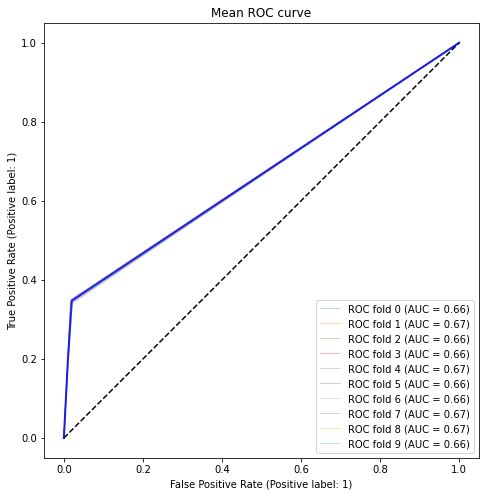

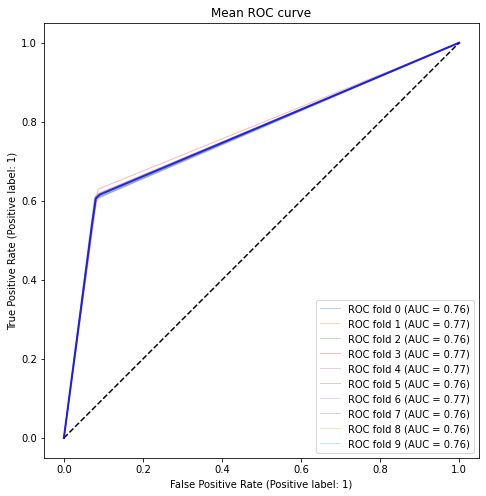

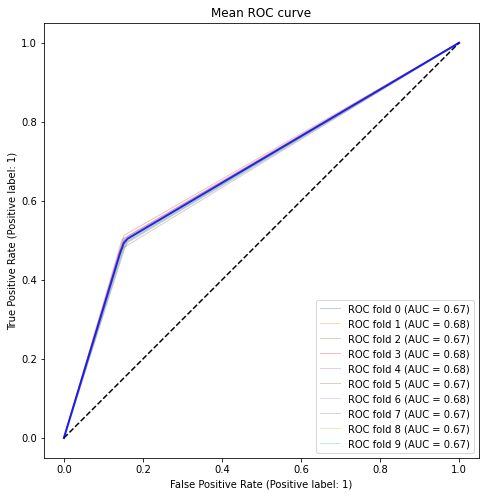

In [ ]:
features_included = [
         'eigenvector_score',
         'harmonic_closeness_centrality',
         'hits_hub',
         'page_rank_score',
         'outDegree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['fake_news_skeleton_combined'], features_included, label_column_name)

classifiers = [
  KNeighborsClassifier(3),
  RandomForestClassifier(n_estimators=300),
  AdaBoostClassifier(),
  # GradientBoostingClassifier(),
]

test_classifiers_with_cv(classifiers, X, y)

## Test classifiers for MIB combined network of followers

### Test best classifiers for MIB combined and best features

KNeighborsClassifier
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis


,Classifier,Mean Validation Accuracy,Mean Validation Precision,Mean Validation Recall,Mean Validation F1 Score
0,KNeighborsClassifier,99.822,1.000,0.998,0.999
0,DecisionTreeClassifier,99.388,0.996,0.997,0.997
0,RandomForestClassifier,99.397,0.996,0.997,0.997
0,AdaBoostClassifier,98.626,0.996,0.988,0.992
0,GradientBoostingClassifier,99.388,0.996,0.997,0.997
0,GaussianNB,90.731,0.927,0.973,0.949
0,LinearDiscriminantAnalysis,92.734,0.925,1.000,0.961
0,QuadraticDiscriminantAnalysis,90.615,0.926,0.972,0.948


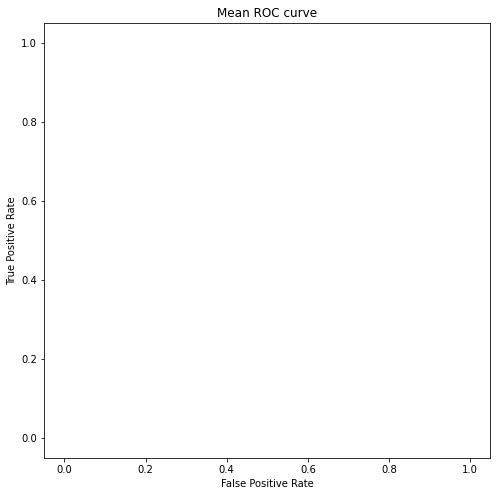

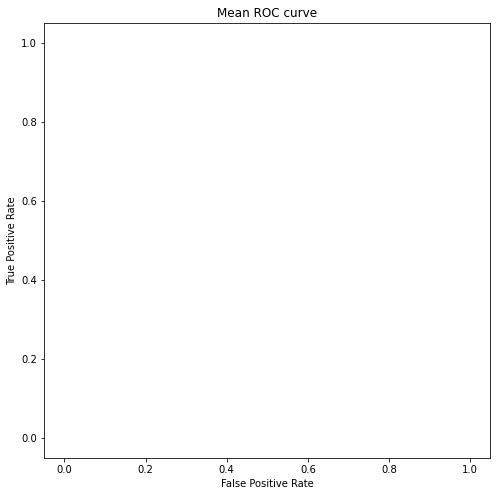

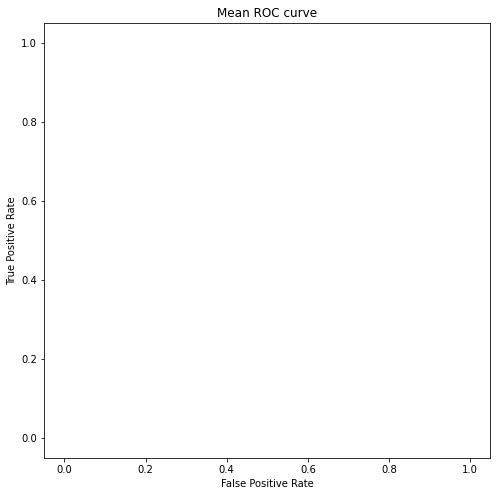

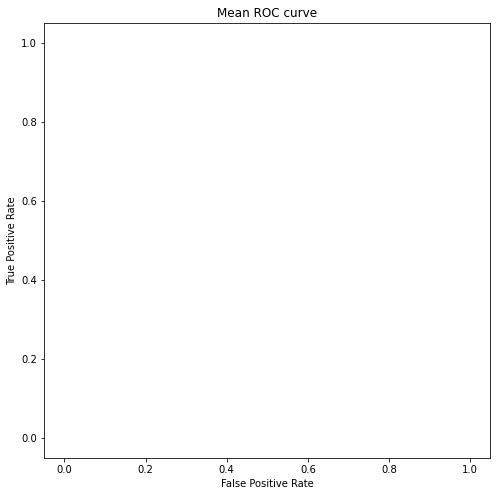

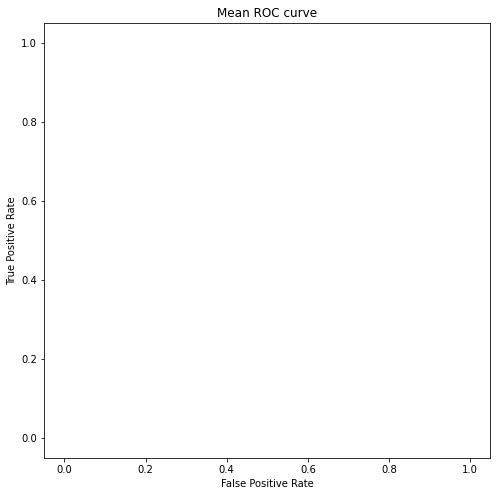

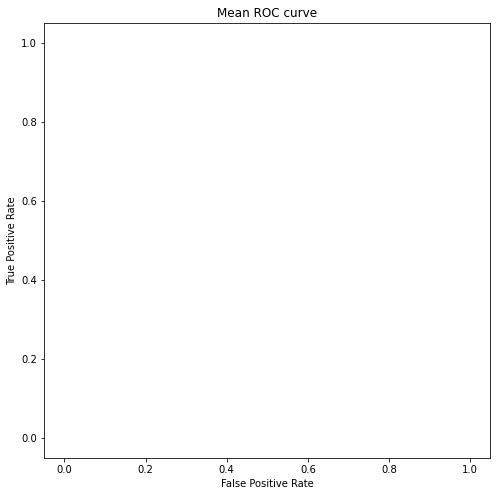

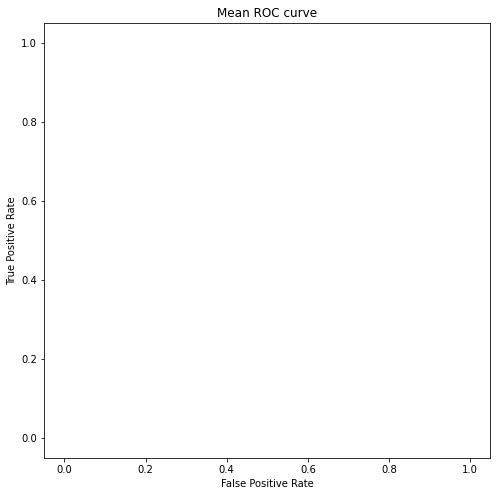

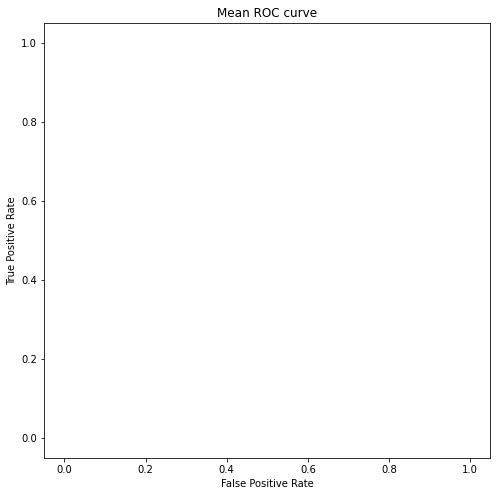

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'page_rank_score'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['mib_combined_at_least_1_degree'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis(),
]

test_classifiers_with_cv(classifiers, X, y)

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'page_rank_score'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['mib_combined_at_least_1_degree'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis(),
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 99.7980%
Log Loss: 0.043411424754208144
DecisionTreeClassifier
****Results****
Accuracy: 99.3721%
Log Loss: 0.025049881507008962
RandomForestClassifier
****Results****
Accuracy: 99.4056%
Log Loss: 0.019888562388078707
AdaBoostClassifier
****Results****
Accuracy: 99.1859%
Log Loss: 0.4442647553369748
GradientBoostingClassifier
****Results****
Accuracy: 99.3494%
Log Loss: 0.021081719870759748
GaussianNB
****Results****
Accuracy: 90.5412%
Log Loss: 0.8194380484018104
LinearDiscriminantAnalysis
****Results****
Accuracy: 92.6914%
Log Loss: 0.31851942716265963
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 90.4109%
Log Loss: 0.7324394163961985


,Classifier,Accuracy,Log Loss
0,KNeighborsClassifier,99.797969,0.043411
0,DecisionTreeClassifier,99.372123,0.025050
0,RandomForestClassifier,99.405635,0.019889
0,AdaBoostClassifier,99.185890,0.444265
0,GradientBoostingClassifier,99.349383,0.021082
0,GaussianNB,90.541152,0.819438
0,LinearDiscriminantAnalysis,92.691445,0.318519
0,QuadraticDiscriminantAnalysis,90.410933,0.732439


In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'page_rank_score'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['mib_combined_at_least_1_degree'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  GradientBoostingClassifier(),
  GaussianNB(),
  AdaBoostClassifier()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

KNeighborsClassifier
****Results****
Accuracy: 99.8035%
Log Loss: 0.04375505657443922
DecisionTreeClassifier
****Results****
Accuracy: 99.3817%
Log Loss: 0.024299021253242868
RandomForestClassifier
****Results****
Accuracy: 99.4224%
Log Loss: 0.019499074942375596
GradientBoostingClassifier
****Results****
Accuracy: 99.3848%
Log Loss: 0.020397927801635508
GaussianNB
****Results****
Accuracy: 90.6520%
Log Loss: 0.8293531074865995


,Classifier,Accuracy,Log Loss
0,KNeighborsClassifier,99.803474,0.043755
0,DecisionTreeClassifier,99.381698,0.024299
0,RandomForestClassifier,99.422391,0.019499
0,GradientBoostingClassifier,99.384810,0.020398
0,GaussianNB,90.651982,0.829353


### Test all classifiers for MIB combined and all features

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['mib_combined_at_least_1_degree'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  KNeighborsClassifier(3),
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  GaussianNB(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis(),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True)
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

## Fake News Net followers best features

DecisionTreeClassifier
RandomForestClassifier
GradientBoostingClassifier
GaussianNB
KNeighborsClassifier
AdaBoostClassifier
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis


,Classifier,Mean Validation Accuracy,Mean Validation Precision,Mean Validation Recall,Mean Validation F1 Score
0,DecisionTreeClassifier,77.693,0.835,0.829,0.832
0,RandomForestClassifier,82.354,0.820,0.942,0.876
0,GradientBoostingClassifier,70.166,0.693,0.991,0.815
0,GaussianNB,66.387,0.670,0.975,0.794
0,KNeighborsClassifier,77.691,0.817,0.856,0.836
0,AdaBoostClassifier,66.894,0.671,0.984,0.798
0,LinearDiscriminantAnalysis,66.729,0.667,0.997,0.799
0,QuadraticDiscriminantAnalysis,66.506,0.670,0.978,0.795


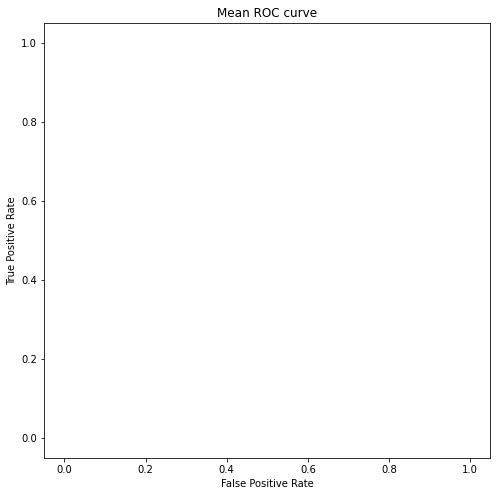

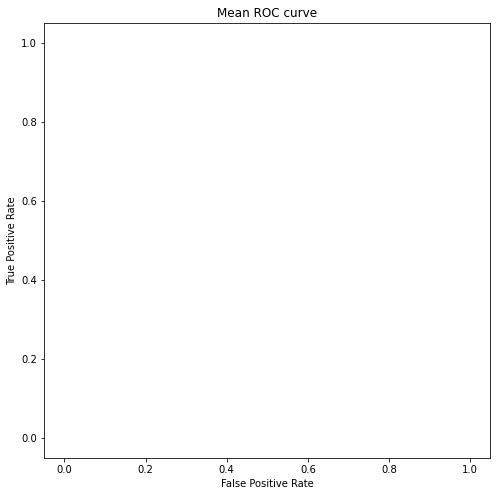

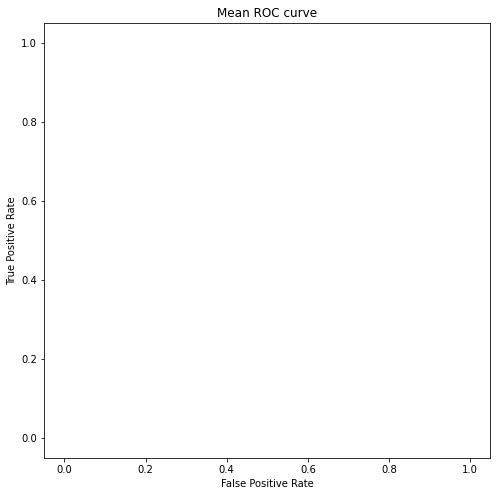

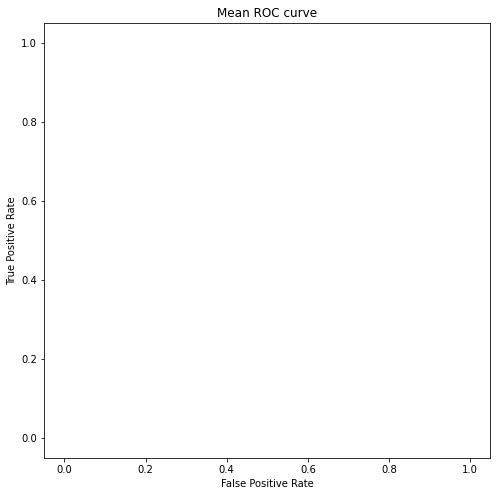

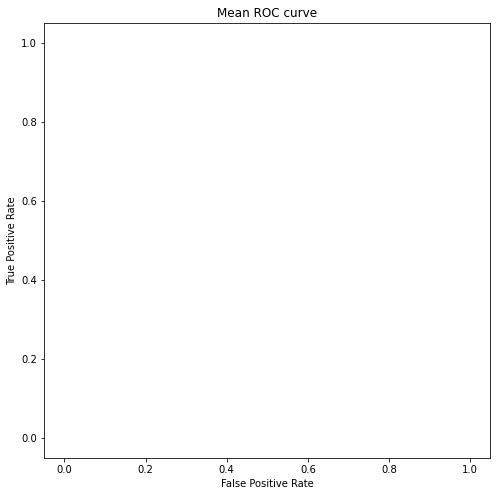

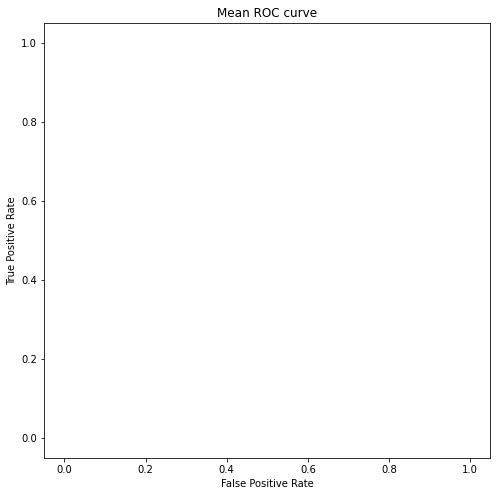

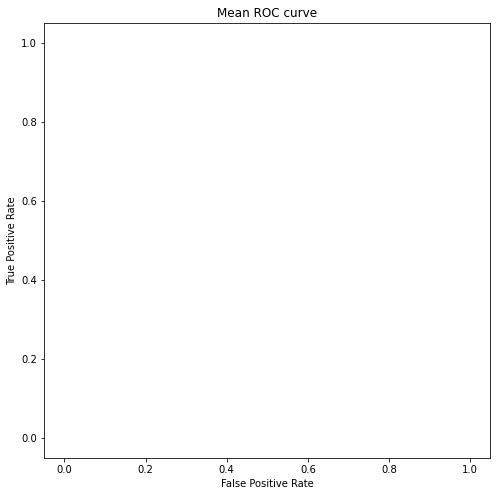

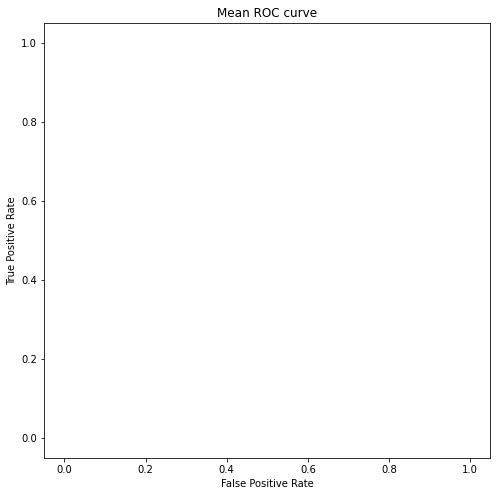

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'page_rank_score'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['fake_news_followers'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  GradientBoostingClassifier(),
  GaussianNB(),
  KNeighborsClassifier(3),
  AdaBoostClassifier(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classifiers_with_cv(classifiers, X, y)

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'page_rank_score'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(datasets['fake_news_followers'], features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  GradientBoostingClassifier(),
  GaussianNB(),
  KNeighborsClassifier(3),
  AdaBoostClassifier(),
  LinearDiscriminantAnalysis(),
  QuadraticDiscriminantAnalysis()
]

test_classfiers(classifiers, X_train, X_test, y_train, y_test)

DecisionTreeClassifier
****Results****
Accuracy: 77.4537%
Log Loss: 7.783594753235686
RandomForestClassifier
****Results****
Accuracy: 82.0352%
Log Loss: 0.34590939941795057
GradientBoostingClassifier
****Results****
Accuracy: 70.1839%
Log Loss: 0.583535091510882
GaussianNB
****Results****
Accuracy: 66.3305%
Log Loss: 0.8147200714188709
KNeighborsClassifier
****Results****
Accuracy: 77.4844%
Log Loss: 2.7095567048539735
AdaBoostClassifier
****Results****
Accuracy: 66.8878%
Log Loss: 0.6902389434300036
LinearDiscriminantAnalysis
****Results****
Accuracy: 66.6597%
Log Loss: 0.6347193247341856
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 66.4111%
Log Loss: 0.790247368711647


,Classifier,Accuracy,Precision,Recall,f1,Log Loss
0,DecisionTreeClassifier,77.454,0.832,0.828,0.830,7.784
0,RandomForestClassifier,82.035,0.816,0.941,0.874,0.346
0,GradientBoostingClassifier,70.184,0.693,0.990,0.815,0.584
0,GaussianNB,66.330,0.669,0.975,0.794,0.815
0,KNeighborsClassifier,77.484,0.814,0.857,0.835,2.710
0,AdaBoostClassifier,66.888,0.670,0.987,0.798,0.690
0,LinearDiscriminantAnalysis,66.660,0.667,0.997,0.799,0.635
0,QuadraticDiscriminantAnalysis,66.411,0.669,0.978,0.795,0.790


### Al user followers combined


RandomForestClassifier
GradientBoostingClassifier
KNeighborsClassifier
AdaBoostClassifier


,Classifier,Mean Validation Accuracy,Mean Validation Precision,Mean Validation Recall,Mean Validation F1 Score
0,RandomForestClassifier,93.109,0.937,0.981,0.958
0,GradientBoostingClassifier,87.988,0.875,0.994,0.930
0,KNeighborsClassifier,91.647,0.942,0.955,0.949
0,AdaBoostClassifier,84.504,0.870,0.950,0.908


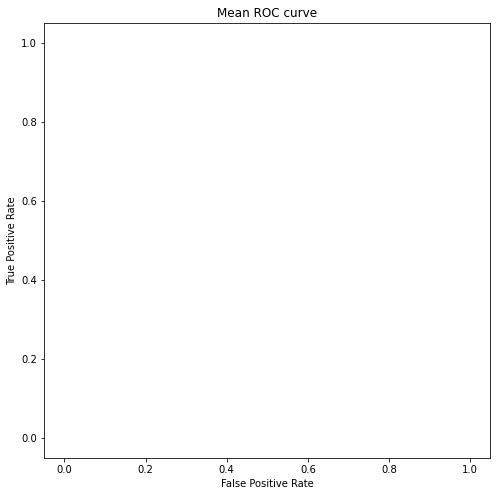

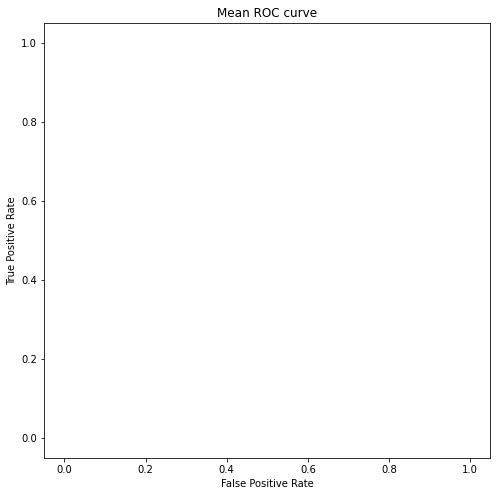

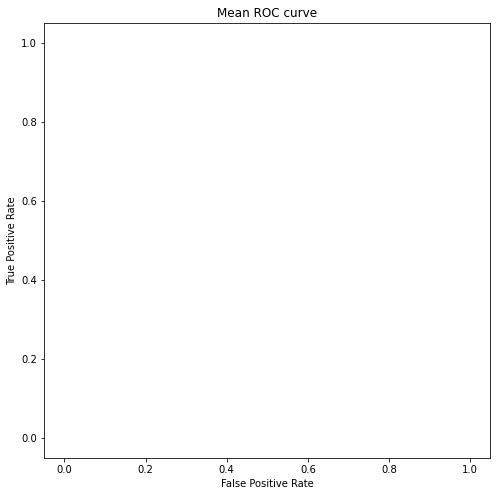

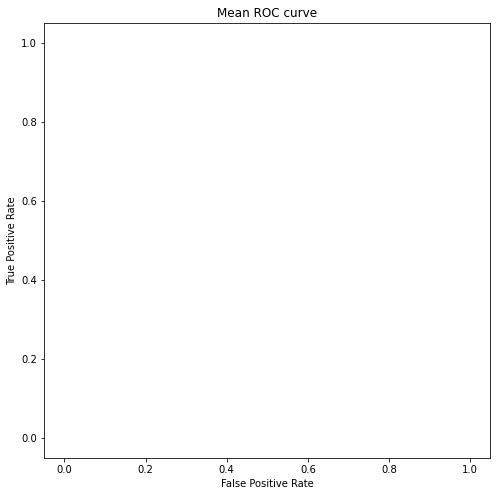

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'page_rank_score'
        ]
label_column_name = 'user.label'
df_combined = pd.concat([datasets['fake_news_followers'], datasets['mib_combined_at_least_1_degree']])
X, y = split_into_X_y(df_combined, features_included, label_column_name)


classifiers = [
  RandomForestClassifier(n_estimators=300),
  GradientBoostingClassifier(),
  KNeighborsClassifier(3),
  AdaBoostClassifier(),
]

test_classifiers_with_cv(classifiers, X, y)

*italicised text*

## MIB model on FakeNewsNet followers dataset and the other way round

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'page_rank_score'
        ]
label_column_name = 'user.label'
X_fake_news_followers, y_fake_news_followers = split_into_X_y(datasets['fake_news_followers'], features_included, label_column_name)
X_mib, y_mib = split_into_X_y(datasets['mib_combined_at_least_1_degree'], features_included, label_column_name)


classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  GradientBoostingClassifier(),
  GaussianNB(),
  KNeighborsClassifier(3),
  AdaBoostClassifier(),
]
test_classfiers(classifiers, X_mib, X_fake_news_followers, y_mib, y_fake_news_followers)
test_classfiers(classifiers, X_fake_news_followers, X_mib, y_fake_news_followers, y_mib)

DecisionTreeClassifier
****Results****
Accuracy: 33.5275%
Log Loss: 22.95793448035987
RandomForestClassifier
****Results****
Accuracy: 33.5092%
Log Loss: 2.257188831183078
GradientBoostingClassifier
****Results****
Accuracy: 33.5093%
Log Loss: 5.118342326388591
GaussianNB
****Results****
Accuracy: 33.5099%
Log Loss: 22.278125649775003
KNeighborsClassifier
****Results****
Accuracy: 33.5548%
Log Loss: 22.911567637503772
AdaBoostClassifier
****Results****
Accuracy: 33.5089%
Log Loss: 0.8979969321816303


,Classifier,Accuracy,Precision,Recall,f1,Log Loss
0,DecisionTreeClassifier,33.527,0.708,0.001,0.001,22.958
0,RandomForestClassifier,33.509,0.733,0.000,0.000,2.257
0,GradientBoostingClassifier,33.509,0.750,0.000,0.000,5.118
0,GaussianNB,33.510,0.765,0.000,0.000,22.278
0,KNeighborsClassifier,33.555,0.669,0.001,0.003,22.912
0,AdaBoostClassifier,33.509,0.721,0.000,0.000,0.898


DecisionTreeClassifier
****Results****
Accuracy: 34.1554%
Log Loss: 22.753266945656645
RandomForestClassifier
****Results****
Accuracy: 87.0182%
Log Loss: 0.6677260845936198
GradientBoostingClassifier
****Results****
Accuracy: 89.3419%
Log Loss: 0.3762344720638089
GaussianNB
****Results****
Accuracy: 8.7616%
Log Loss: 5.609308709738107
KNeighborsClassifier
****Results****
Accuracy: 89.9556%
Log Loss: 3.4865618614908107
AdaBoostClassifier
****Results****
Accuracy: 90.2372%
Log Loss: 0.6831555681041351


,Classifier,Accuracy,Precision,Recall,f1,Log Loss
0,DecisionTreeClassifier,34.155,0.772,0.368,0.498,22.753
0,RandomForestClassifier,87.018,0.894,0.969,0.930,0.668
0,GradientBoostingClassifier,89.342,0.894,0.998,0.943,0.376
0,GaussianNB,8.762,0.000,0.000,0.000,5.609
0,KNeighborsClassifier,89.956,0.901,0.996,0.946,3.487
0,AdaBoostClassifier,90.237,0.903,0.998,0.948,0.683


In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'page_rank_score'
        ]
label_column_name = 'user.label'
X_fake_news_followers, y_fake_news_followers = split_into_X_y(datasets['fake_news_followers'], features_included, label_column_name)
X_mib, y_mib = split_into_X_y(datasets['mib_combined_at_least_1_degree'], features_included, label_column_name)


classifiers = [
  DecisionTreeClassifier(),
  RandomForestClassifier(n_estimators=300),
  GradientBoostingClassifier(),
  GaussianNB(),
  KNeighborsClassifier(3),
  AdaBoostClassifier(),
]

test_classfiers(classifiers, X_fake_news_followers, X_mib, y_fake_news_followers, y_mib)

DecisionTreeClassifier
****Results****
Accuracy: 33.8671%
Log Loss: 22.852851072615813
RandomForestClassifier
****Results****
Accuracy: 86.1350%
Log Loss: 0.6851866430223772
GradientBoostingClassifier
****Results****
Accuracy: 89.3419%
Log Loss: 0.37623566741555237
GaussianNB
****Results****
Accuracy: 8.7616%
Log Loss: 5.609308709738107
KNeighborsClassifier
****Results****
Accuracy: 89.9556%
Log Loss: 3.4865618614908107
AdaBoostClassifier
****Results****
Accuracy: 90.2372%
Log Loss: 0.6831555681041035


,Classifier,Accuracy,Log Loss
0,DecisionTreeClassifier,33.867089,22.852851
0,RandomForestClassifier,86.135023,0.685187
0,GradientBoostingClassifier,89.341864,0.376236
0,GaussianNB,8.761579,5.609309
0,KNeighborsClassifier,89.955570,3.486562
0,AdaBoostClassifier,90.237217,0.683156
